GENERATING GRAPH WITH 15° DIAGONAL
Generating approximately 282 hexagon centers
Diagonal angle: 15°
Average nearest neighbor distance: 11.45°
Neighbor threshold: 17.17°
Total edges: 840


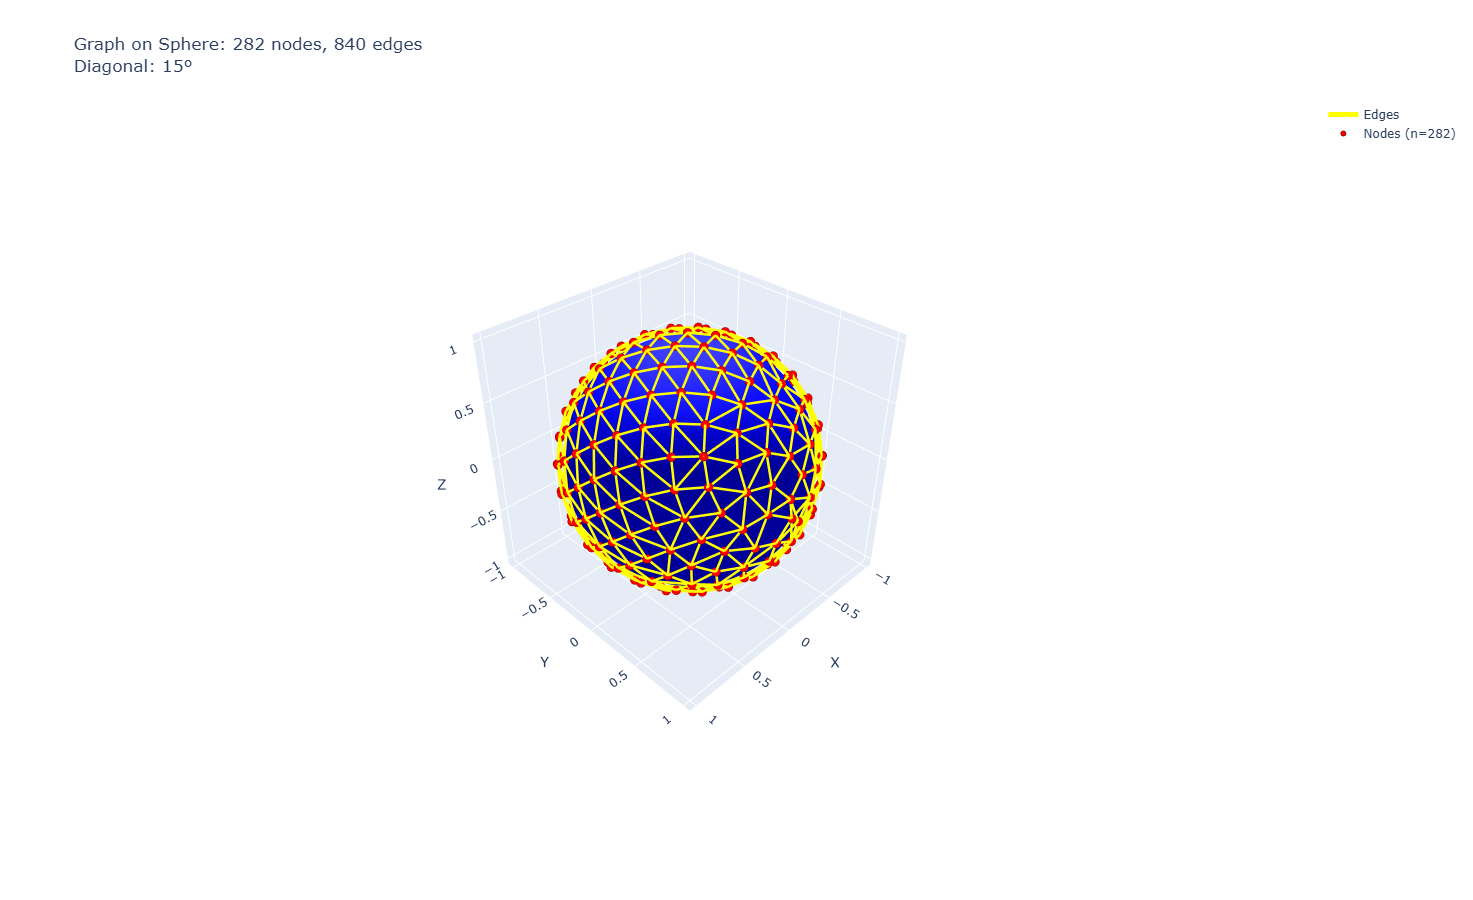


GRAPH STATISTICS
Number of nodes: 282
Number of edges: 840
Average degree: 5.96
Min degree: 5
Max degree: 7
Most common degree: 6


In [1]:
import numpy as np
import plotly.graph_objects as go

def generate_hexagon_centers(diagonal_angle_degrees=7.5):
    """
    Generate hexagon centers for tessellating a sphere.
    Uses a fibonacci sphere or icosahedron-based approach.
    
    For 7.5° diagonal, we need approximately:
    - Sphere surface area = 4π
    - Hexagon area ≈ (diagonal/2)^2 * 3*sqrt(3)/2 in steradians
    - Number of hexagons ≈ 4π / hexagon_area
    """
    
    # Convert diagonal angle to radians
    diagonal_rad = np.radians(diagonal_angle_degrees)
    
    # Estimate number of points needed
    # For hexagon with diagonal d, area ≈ 0.65 * d^2 (in steradians for small angles)
    hexagon_area = 0.65 * diagonal_rad**2
    n_points = int(4 * np.pi / hexagon_area)
    
    print(f"Generating approximately {n_points} hexagon centers")
    print(f"Diagonal angle: {diagonal_angle_degrees}°")
    
    # Use Fibonacci sphere algorithm for uniform distribution
    centers = []
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    
    for i in range(n_points):
        # Fibonacci sphere algorithm
        y = 1 - (2 * i / (n_points - 1))  # y goes from 1 to -1
        radius = np.sqrt(1 - y**2)
        
        theta = 2 * np.pi * i / phi
        
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        
        centers.append([x, y, z])
    
    return np.array(centers)

def visualize_hexagon_centers(centers, diagonal_angle_degrees=7.5, show_circles=True):
    """
    Visualize the hexagon centers on a sphere.
    """
    # Create sphere surface
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    
    fig = go.Figure()
    
    # Add semi-transparent blue sphere
    fig.add_trace(go.Surface(
        x=x, y=y, z=z,
        surfacecolor=np.zeros_like(x),
        colorscale=[[0, 'lightblue'], [1, 'lightblue']],
        showscale=False,
        opacity=0.3,
        name='Sphere'
    ))
    
    # Add hexagon centers as red points
    fig.add_trace(go.Scatter3d(
        x=centers[:, 0],
        y=centers[:, 1],
        z=centers[:, 2],
        mode='markers',
        marker=dict(size=4, color='red'),
        name=f'Hexagon Centers (n={len(centers)})'
    ))
    
    # Optionally show circles around each center
    if show_circles and len(centers) <= 50:  # Limit for performance
        arc_angle = diagonal_angle_degrees / 2  # Radius is half the diagonal
        
        for idx, center in enumerate(centers[:50]):  # Show first 50
            # Generate circle points
            circle_points = generate_circle_on_sphere(center, arc_angle)
            
            fig.add_trace(go.Scatter3d(
                x=circle_points[:, 0],
                y=circle_points[:, 1],
                z=circle_points[:, 2],
                mode='lines',
                line=dict(color='green', width=2),
                showlegend=False,
                hoverinfo='skip'
            ))
    
    fig.update_layout(
        title=f'Hexagonal Tessellation of Sphere<br>{len(centers)} centers, {diagonal_angle_degrees}° diagonal',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data',
            camera=dict(eye=dict(x=1.8, y=1.8, z=1.8))
        ),
        width=900,
        height=900
    )
    
    return fig

def generate_circle_on_sphere(center, arc_angle_degrees, n_points=50):
    """
    Generate points forming a circle on sphere surface around a center point.
    """
    center = center / np.linalg.norm(center)
    arc_angle_rad = np.radians(arc_angle_degrees)
    
    # Find two orthogonal vectors perpendicular to center
    if abs(center[2]) < 0.9:
        v1 = np.cross(center, [0, 0, 1])
    else:
        v1 = np.cross(center, [1, 0, 0])
    v1 = v1 / np.linalg.norm(v1)
    v2 = np.cross(center, v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Generate circle points
    circle_points = []
    angles = np.linspace(0, 2 * np.pi, n_points)
    
    for angle in angles:
        # Point on circle at angular distance arc_angle_rad from center
        direction = np.cos(angle) * v1 + np.sin(angle) * v2
        direction = direction / np.linalg.norm(direction)
        
        # Rotate center towards direction by arc_angle_rad
        point = (np.cos(arc_angle_rad) * center + 
                np.sin(arc_angle_rad) * direction)
        point = point / np.linalg.norm(point)
        
        circle_points.append(point)
    
    return np.array(circle_points)

# # Generate centers
# centers = generate_hexagon_centers(diagonal_angle_degrees=7.5)

# # Print first 20 centers as examples
# print("\nFirst 20 hexagon centers (unit vectors):")
# print("="*50)
# for i, center in enumerate(centers[:20]):
#     print(f"{i+1:3d}: ({center[0]:7.4f}, {center[1]:7.4f}, {center[2]:7.4f})")

# print(f"\n... and {len(centers)-20} more centers")
# print(f"\nTotal centers: {len(centers)}")

# # Visualize
# fig = visualize_hexagon_centers(centers, diagonal_angle_degrees=7.5, show_circles=False)
# fig.show()

def find_neighbors(centers, max_distance_factor=1.5):
    """
    Find neighboring points for each center.
    Two points are neighbors if their angular distance is within max_distance_factor times the average.
    """
    n = len(centers)
    
    # Calculate average nearest neighbor distance
    min_distances = []
    for i in range(min(100, n)):  # Sample first 100 points
        distances = []
        for j in range(n):
            if i != j:
                # Angular distance between unit vectors
                cos_angle = np.clip(np.dot(centers[i], centers[j]), -1, 1)
                angle = np.arccos(cos_angle)
                distances.append(angle)
        min_distances.append(min(distances))
    
    avg_min_distance = np.mean(min_distances)
    threshold = avg_min_distance * max_distance_factor
    
    print(f"Average nearest neighbor distance: {np.degrees(avg_min_distance):.2f}°")
    print(f"Neighbor threshold: {np.degrees(threshold):.2f}°")
    
    # Find all neighbors
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            cos_angle = np.clip(np.dot(centers[i], centers[j]), -1, 1)
            angle = np.arccos(cos_angle)
            
            if angle <= threshold:
                edges.append((i, j))
    
    print(f"Total edges: {len(edges)}")
    return edges

def visualize_graph_on_sphere(centers, edges, diagonal_angle_degrees=15):
    """
    Visualize the graph with nodes and edges on the sphere.
    """
    # Create sphere surface
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    
    fig = go.Figure()
    
    # Add opaque blue sphere
    fig.add_trace(go.Surface(
        x=x*.95, y=y*.95, z=z*.95,
        surfacecolor=np.zeros_like(x),
        colorscale=[[0, 'blue'], [1, 'blue']],
        showscale=False,
        opacity=1.0,
        name='Sphere',
        lighting=dict(ambient=0.6, diffuse=0.8, specular=0.2)
    ))
    
    # Add edges
    edge_x, edge_y, edge_z = [], [], []
    for i, j in edges:
        # Add edge between centers[i] and centers[j]
        edge_x.extend([centers[i][0], centers[j][0], None])
        edge_y.extend([centers[i][1], centers[j][1], None])
        edge_z.extend([centers[i][2], centers[j][2], None])
    
    fig.add_trace(go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='yellow', width=5),
        hoverinfo='none',
        name='Edges'
    ))
    
    # Add nodes
    fig.add_trace(go.Scatter3d(
        x=centers[:, 0],
        y=centers[:, 1],
        z=centers[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color='red',
            line=dict(color='darkred', width=1)
        ),
        name=f'Nodes (n={len(centers)})',
        text=[f'Node {i}' for i in range(len(centers))],
        hoverinfo='text'
    ))
    
    fig.update_layout(
        title=f'Graph on Sphere: {len(centers)} nodes, {len(edges)} edges<br>Diagonal: {diagonal_angle_degrees}°',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data',
            camera=dict(eye=dict(x=1.8, y=1.8, z=1.8))
        ),
        width=900,
        height=900,
        showlegend=True
    )
    
    return fig

# Generate centers with 15° spacing
print("="*60)
print("GENERATING GRAPH WITH 15° DIAGONAL")
print("="*60)
centers_small = generate_hexagon_centers(diagonal_angle_degrees=15)

# Find neighbors and create edges
edges = find_neighbors(centers_small, max_distance_factor=1.5)

# Visualize the graph
fig_graph = visualize_graph_on_sphere(centers_small, edges, diagonal_angle_degrees=15)
fig_graph.show()

# Also show statistics
print("\n" + "="*60)
print("GRAPH STATISTICS")
print("="*60)
print(f"Number of nodes: {len(centers_small)}")
print(f"Number of edges: {len(edges)}")
print(f"Average degree: {2*len(edges)/len(centers_small):.2f}")

# Count degree distribution
degree_count = {i: 0 for i in range(len(centers_small))}
for i, j in edges:
    degree_count[i] += 1
    degree_count[j] += 1

degrees = list(degree_count.values())
print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Most common degree: {max(set(degrees), key=degrees.count)}")

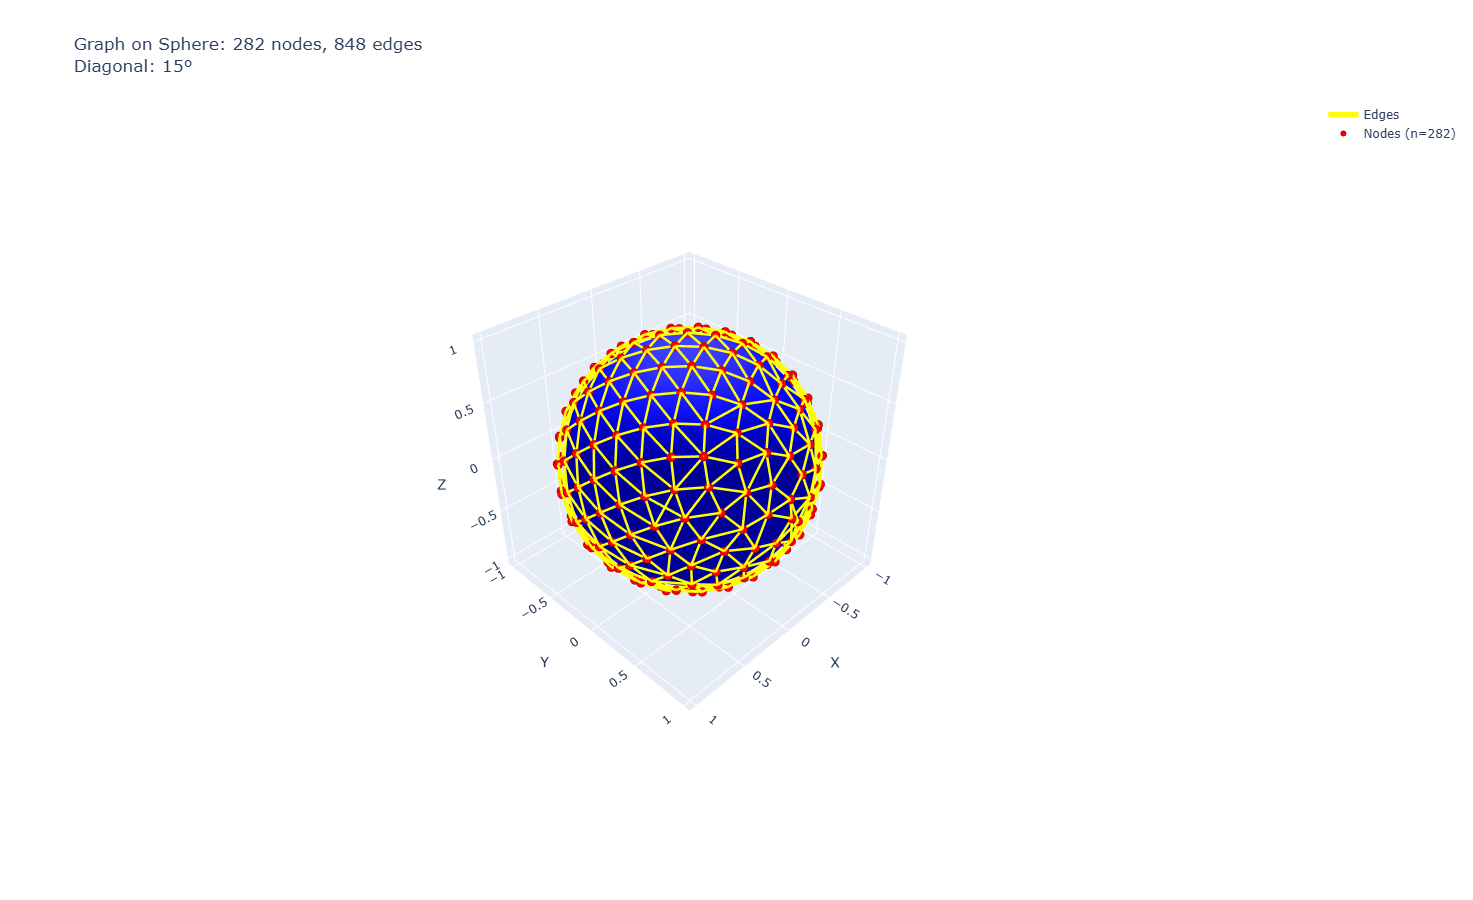

In [6]:
from math import *

def find_edges(ps):
    # find_neighbors(ps)
    lmt = 0.954555620192181
    res = []
    # ylmt=0.3026311666666667
    for i in range(0, len(ps)-1):
        theta = acos(1-abs(ps[i][1]))
        ylmt = max(abs(sin(0.3+theta)), sin(theta))*0.3 + ps[i][1]
        j = i+1
        while ps[j][1] < ylmt:
            if np.dot(ps[i], ps[j]) > lmt:
                res.append((i, j))
            j += 1
            if j>=len(ps):
                break
    return res

e2=find_edges(centers_small)
fig_graph = visualize_graph_on_sphere(centers_small, e2, diagonal_angle_degrees=15)
fig_graph.show()

In [7]:
import numpy as np
import plotly.graph_objects as go

def create_sphere_with_circle(points):
    """
    Create a blue sphere with a green circular region.
    
    Parameters:
    - center_vector: tuple (x, y, z) - unit vector pointing to circle center
    - arc_angle_degrees: float - angular radius of the green circle in degrees
    """
    
    # Create sphere coordinates
    u = np.linspace(0, 2 * np.pi, 200)
    v = np.linspace(0, np.pi, 200)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Initialize colors - all blue
    colors = np.zeros_like(x)
    
    for center_vector, arc_angle_degrees in points:
        # Normalize the center vector to ensure it's a unit vector
        center = np.array(center_vector)
        center = center / np.linalg.norm(center)
    
        # Convert arc angle to radians
        arc_angle_rad = np.radians(arc_angle_degrees)
        
        # Calculate angular distance from center point for each point on sphere
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                # Current point on sphere
                point = np.array([x[i, j], y[i, j], z[i, j]])
                
                # Calculate angular distance using dot product
                # cos(angle) = dot(v1, v2) for unit vectors
                cos_angle = np.dot(point, center)
                # Clamp to [-1, 1] to avoid numerical errors
                cos_angle = np.clip(cos_angle, -1, 1)
                angle = np.arccos(cos_angle)
                
                # If within the circle radius, color it green (1), else blue (0)
                if angle <= arc_angle_rad:
                    colors[i, j] = 1
        
    # Create custom colorscale: 0 = blue, 1 = green
    colorscale = [[0, 'blue'], [1, 'green']]
    
    # Create the 3D surface plot
    fig = go.Figure(data=[go.Surface(
        x=x, y=y, z=z,
        surfacecolor=colors,
        colorscale=colorscale,
        showscale=False,
        cmin=0,
        cmax=1
    )])
    
    # Add a marker at the center point for reference
    fig.add_trace(go.Scatter3d(
        x=[center[0]],
        y=[center[1]],
        z=[center[2]],
        mode='markers',
        marker=dict(size=5, color='red'),
        name='Circle Center'
    ))
    
    # Update layout
    fig.update_layout(
        title=f'Sphere with Green Circle<br>Center: ({center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f}), Arc Angle: {arc_angle_degrees}°',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=800
    )
    
    return fig

make_fig = create_sphere_with_circle


In [9]:
def get_pNe():
    ps=centers_small
    es=find_edges(centers_small)
    return ps, es


In [13]:
import numpy as np
from random import randint
from math import *


def gen_dirs(n):
    l = list(range(1, n+1))
    for i in range(n-1, 1, -1):
        j = randint(0, i-1)
        l[i], l[j] = l[j], l[i]
    return int(''.join([str(i) for i in l]))

def gen():
    ps, es = get_pNe()
    N = len(ps)
    vis = [0]*N
    neigb_vis = [0]*N
    e = []
    for i in range(N):
        e.append([])
    for i, j in es:
        e[i].append(j)
        e[j].append(i)
    d = [len(i) for i in e]
    vis[0] = 1
    for neigbor in e[0]:
        neigb_vis[neigbor] += 1
    stack = [0]
    stackd = [gen_dirs(d[0])]
    while len(stack) > 0:
        point = stack.pop()
        dirs = stackd.pop()
        # print(point, dirs)
        if neigb_vis[point] > 2:
            continue
        while dirs > 0:
            nxt = e[point][dirs % 10-1]
            dirs = dirs//10
            # print(nxt)
            if vis[nxt]:
                continue
            if neigb_vis[nxt] > 2 and neigb_vis[point] == 2:
                continue
            if neigb_vis[nxt] > 1 and neigb_vis[point] <= 1:
                continue
            # print(nxt)
            vis[nxt] = 1
            for nxt_neib in e[nxt]:
                neigb_vis[nxt_neib] += 1
            if dirs > 0:
                stack.append(point)
                stackd.append(dirs)
            stack.append(nxt)
            stackd.append(gen_dirs(d[nxt]))
            break
    return vis




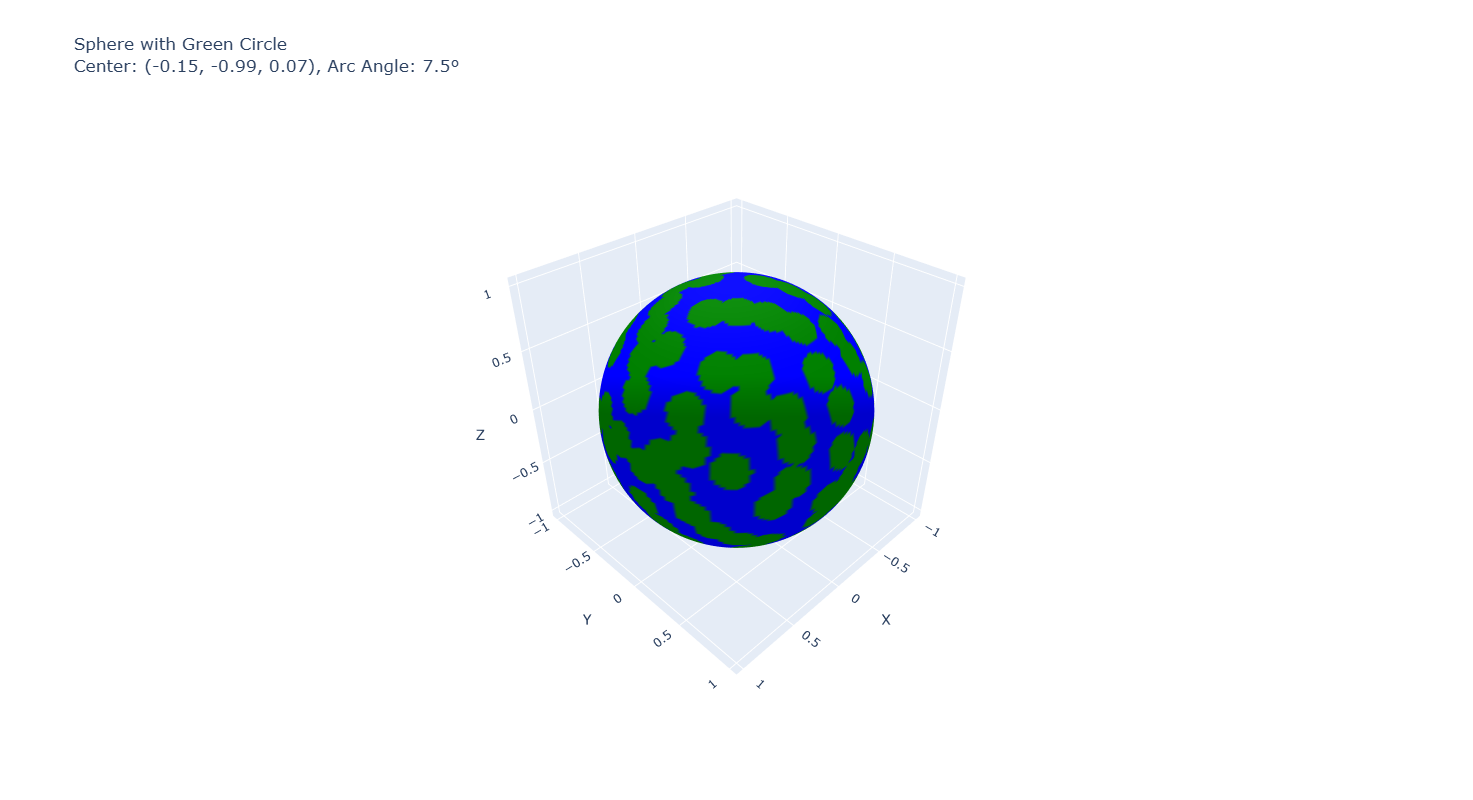

In [17]:
vis=gen()
fig = make_fig([(p,7.5) for i,p in enumerate(centers_small) if vis[i]==0 ])
fig.show()